# Image segmentation using Vanilla UNet, UNet with ResNeXt50 backbone, and Feature Pyramid Network.

**Steps**:
+ **Data Preparation**

+ **Data Visualization**

+ **Data Augmentaions**

+ **UNet ResNeXt50**

+ **Train Models**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**


In [26]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

plt.style.use("dark_background")

Global Variable

In [27]:
# Path to all data
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [28]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [29]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_29.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_29_mask.tif


Final dataframe

In [30]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


## Data Distribution

Distribution of positive/negative diagnosis

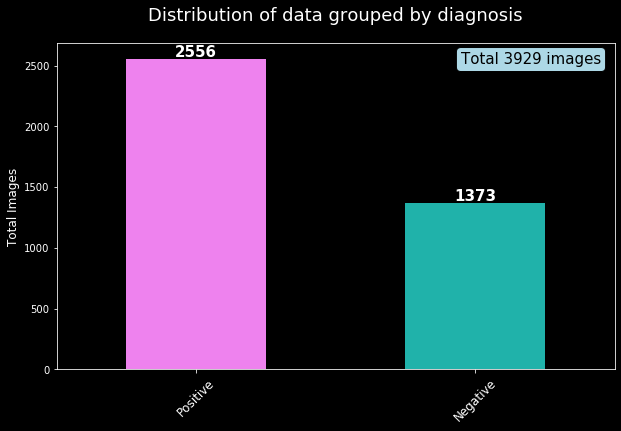

In [31]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Distribution of positive/negative diagnosis between each patient

## Data Visualization

Samples of images with a positive and negative diagnosis

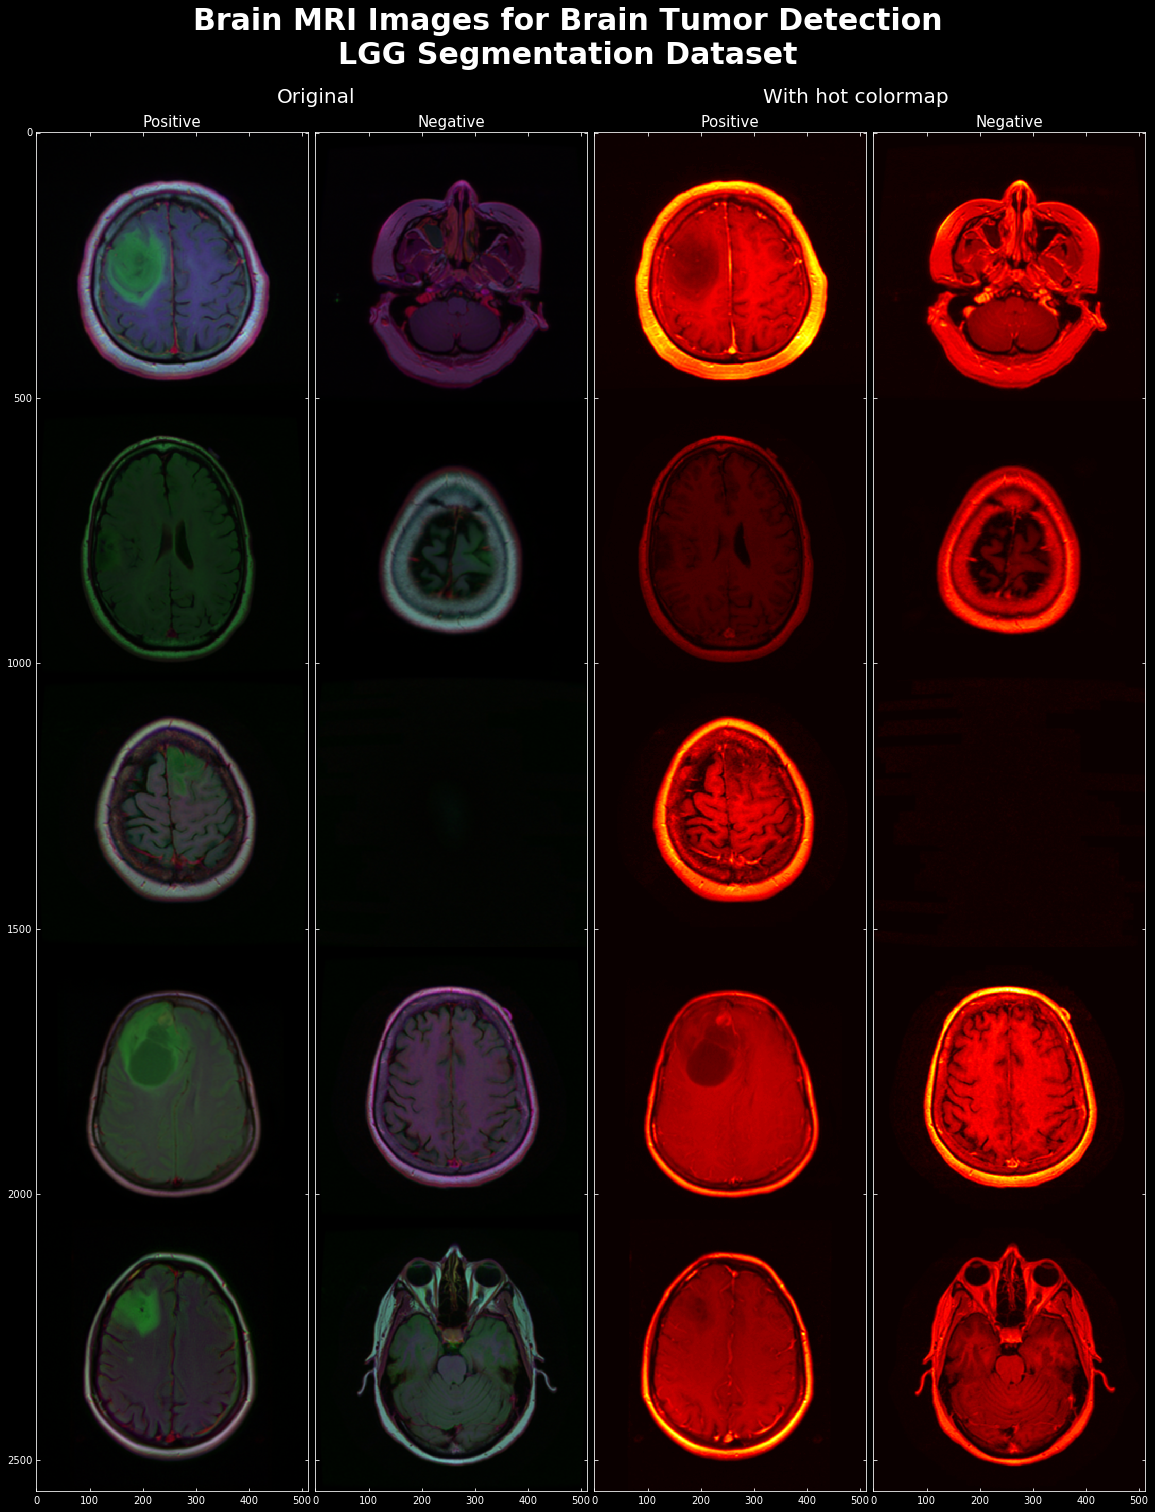

In [33]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

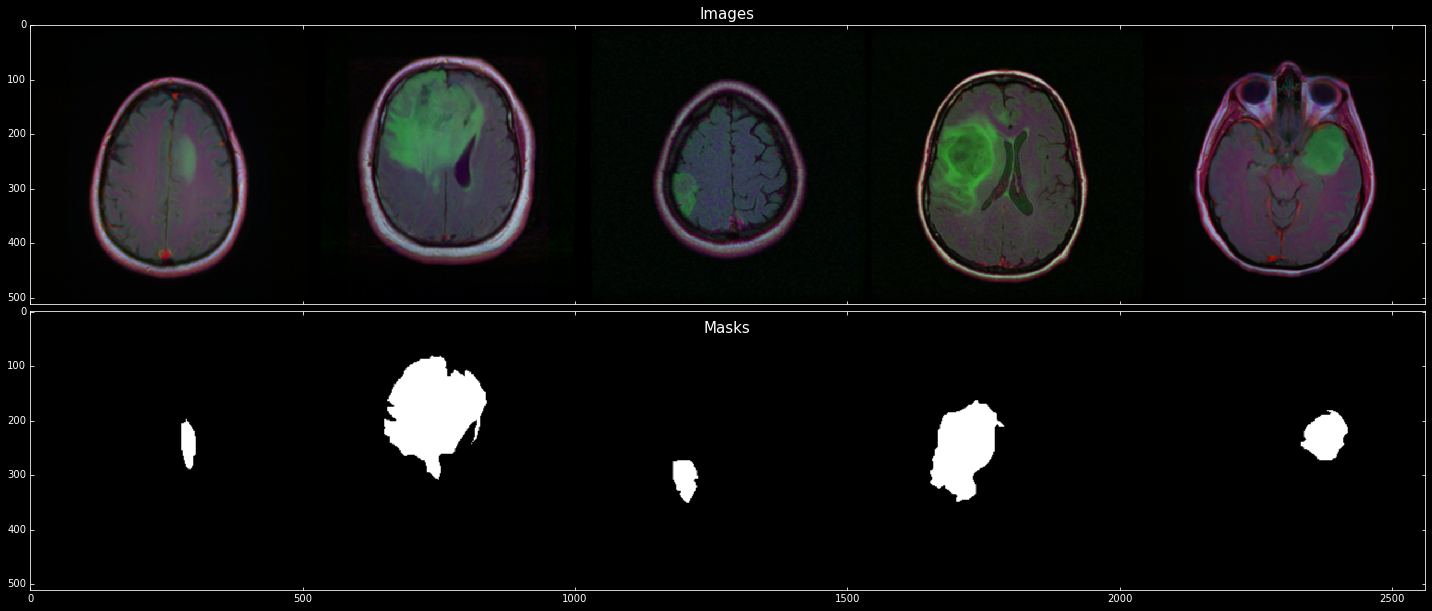

In [34]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

# DataGenerator and Data Augmentation

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DataGenerator

In [37]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)       

transforms

In [ ]:
PATCH_SIZE = 128#256

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensor(),
])

Split data on train val test

In [39]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [40]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

Augmentation Visualization

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


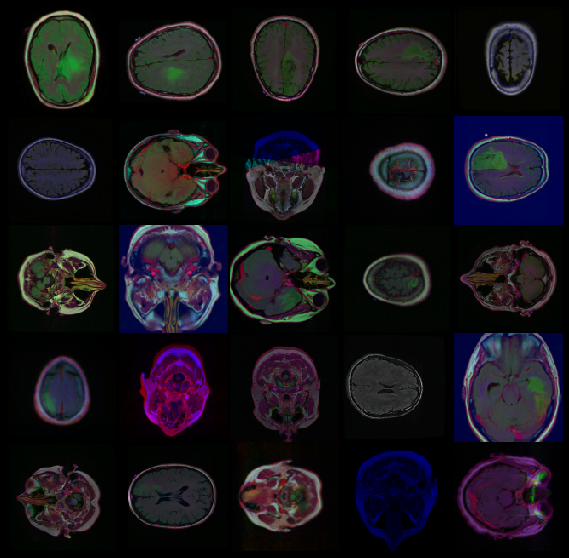

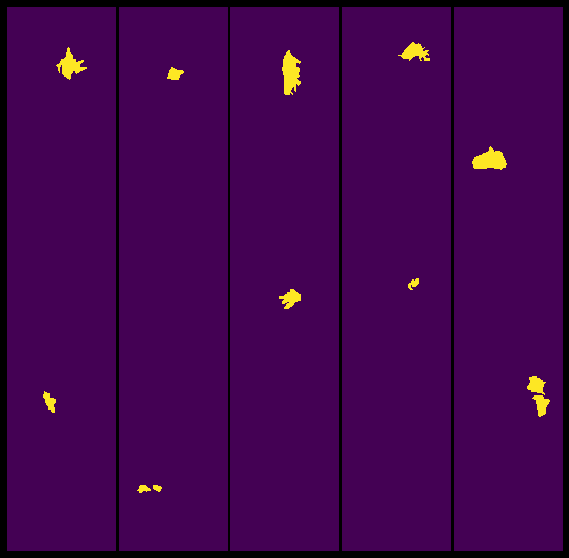

In [41]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# Model Zoo

## Unet with ResNeXt50 backbone.

In [64]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [70]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=False)
        self.base_model.load_state_dict(torch.load("/kaggle/input/resnext50-32x4d-7cdf4587-pth/resnext50_32x4d-7cdf4587.pth"))

        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [71]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# Segmentation Quality Metric


Intuitive interpretation  |  Formula depending on the type of coefficient
:------------------------:|:-------------------------:
![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png) | ![](https://d3i71xaburhd42.cloudfront.net/8575e8beef47bd2880c92f54a749f933db983e56/2-Table1-1.png)



In [72]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

# Segmentation Loss



<p> 
    <img src="https://miro.medium.com/max/1400/0*u6iEAiz9smASIhuk" width="450" height="300">
</p>

In [73]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Train Models

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs, patience=5):  
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    best_val_score = 0.0  # لمتابعة أفضل DICE
    epochs_no_improve = 0  # عداد لفترة عدم التحسن
    
    for epoch in range(num_epochs):
        model.train()  # وضع التدريب
        
        losses = []
        train_iou = []
                
        
            
            
            
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            
                
        
 
        # حساب DICE على validation
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.mean(losses))
        train_history.append(np.mean(train_iou))
        val_history.append(val_mean_iou)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {np.mean(losses):.4f} - Train DICE: {np.mean(train_iou):.4f} - Val DICE: {val_mean_iou:.4f}")
        
        # Early Stopping & حفظ أفضل موديل
        if val_mean_iou > best_val_score:
            best_val_score = val_mean_iou
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"💾 Best model saved at epoch {epoch+1} with Val DICE: {best_val_score:.4f}")
            epochs_no_improve = 0  # إعادة العد
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break
        
    return loss_history, train_history, val_history


In [ ]:
# Optimizers
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

In [ ]:
%%time
num_ep = 20                                                                                                
# Train ResNeXt50
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50
Epoch [1/20] - Train Loss: 0.1362 - Train DICE: 0.8792 - Val DICE: 0.9214
💾 Best model saved at epoch 1 with Val DICE: 0.9214
Epoch [2/20] - Train Loss: 0.1333 - Train DICE: 0.8819 - Val DICE: 0.9079
Epoch [3/20] - Train Loss: 0.1540 - Train DICE: 0.8631 - Val DICE: 0.9162
Epoch [4/20] - Train Loss: 0.1616 - Train DICE: 0.8576 - Val DICE: 0.9123
Epoch [5/20] - Train Loss: 0.1355 - Train DICE: 0.8793 - Val DICE: 0.9337
💾 Best model saved at epoch 5 with Val DICE: 0.9337
Epoch [6/20] - Train Loss: 0.1268 - Train DICE: 0.8873 - Val DICE: 0.9210
Epoch [7/20] - Train Loss: 0.1228 - Train DICE: 0.8902 - Val DICE: 0.9306
Epoch [8/20] - Train Loss: 0.1252 - Train DICE: 0.8891 - Val DICE: 0.9349
💾 Best model saved at epoch 8 with Val DICE: 0.9349
Epoch [9/20] - Train Loss: 0.1226 - Train DICE: 0.8905 - Val DICE: 0.9351
💾 Best model saved at epoch 9 with Val DICE: 0.9351
Epoch [10/20] - Train Loss: 0.1256 - Train DICE: 0.8877 - Val DICE: 0.9516
💾 Best model saved at epoch 10 with Val D

## Train history 

In [96]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()
    

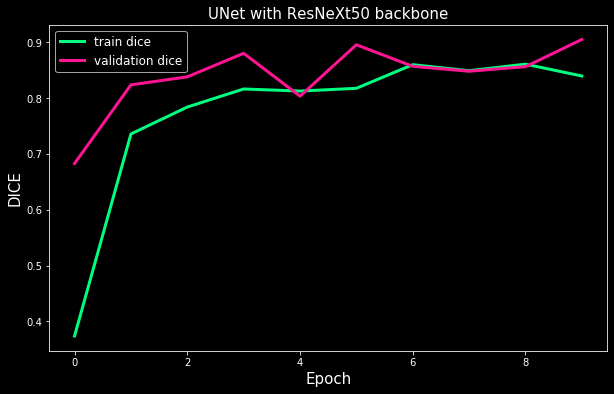

In [ ]:

plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

# Test Prediction

### Test IoU

In [ ]:

test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

ResNext50
Mean IoU of the test images - 92.0%


### random test sample

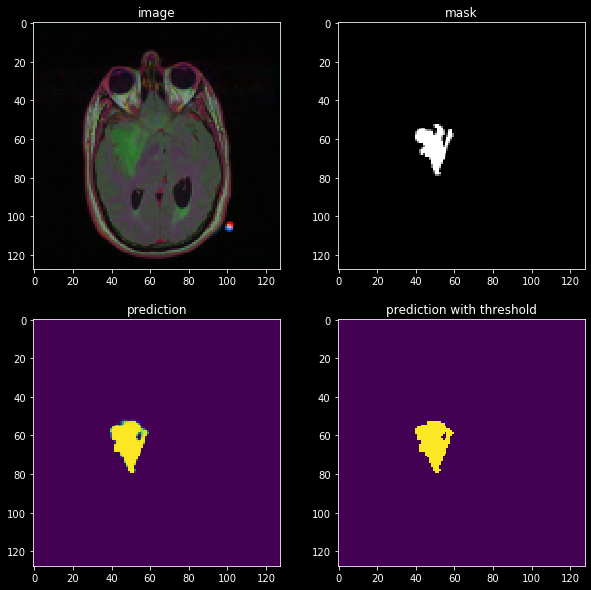

In [99]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()